In [311]:
import io
import requests
import os
import datetime
import urllib.request

import geopandas as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import Point
from shapely.ops import cascaded_union, unary_union

In [131]:
# Load cdec reservoirs
data_dir = "../data"
files = [os.path.join(data_dir, x) for x in os.listdir(data_dir) if "cdec" in x]
df = pd.read_csv(files[0])

# Make a gdf
lats = df.Latitude
longs = df.Longitude
crs = {"init":"epsg:4326"}
geom = [Point(xy) for xy in zip(longs,lats)]
gdf = gp.GeoDataFrame(df, crs = crs, geometry = geom)

# Save
if not os.path.exists("../shape/cdec_reservoirs.shp"):
    gdf.to_file("../shape/cdec_reservoirs.shp")
else:
    pass

In [132]:
# Read the HU4s and merge
s1 = gp.read_file("../shape/1804_4.shp")
s2 = gp.read_file("../shape/1803_4.shp")
s3 = gp.read_file("../shape/1802_4.shp")

ssjt = gp.GeoDataFrame(pd.concat([s1,s2,s3], ignore_index=True))
ssjt.crs = crs

# Read cv
cv = gp.read_file("../shape/cv.shp")

# Make small buffer around cv
buffered_cv = cv.buffer(0.005)
buf = gp.GeoDataFrame(gp.GeoSeries(buffered_cv))
buf = buf.rename(columns={0:'geometry'}).set_geometry('geometry')
buf.crs = crs

# Filter
within_cv = gp.sjoin(gdf, buf, how='inner', op='intersects')
within_ssjt = gp.sjoin(gdf, ssjt, how='inner', op='intersects')

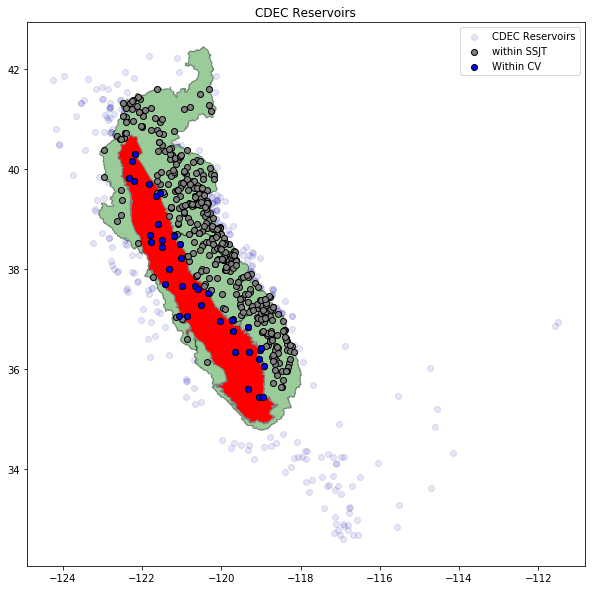

In [175]:
fig, ax = plt.subplots(figsize = (10, 10))

plt.title("CDEC Reservoirs")
ssjt.plot(ax = ax, color = "green", alpha = 0.4, edgecolor = "black",label =  "SSJT HU4 watershed")
cv.plot(ax = ax, color = "red", edgecolor = "gray", label = "CV alluvial fill")
gdf.plot(ax = ax, color = "blue", alpha = 0.1, edgecolor='black', label = "CDEC Reservoirs")
within_ssjt.plot(ax = ax, color = "gray", alpha = 1, edgecolor='black', label = "within SSJT")
within_cv.plot(ax = ax, color = "blue", alpha = 1, edgecolor='black', label = "Within CV")
ax.legend()

plt.show()

In [134]:
within_cv.head()

,Station,ID,Elev (feet),Latitude,Longitude,County,River Basin,Unnamed: 7,geometry,index_right
7,AMERICAN R AT FOLSOM,AMF,0,38.683,-121.183,SACRAMENTO,AMERICAN R,NaN,POINT (-121.183 38.683),0
23,BAKERSFIELD AIRPORT,BFK,494,35.434,-119.054,KERN,TULARE LAKE,NaN,POINT (-119.054 35.434),0
55,BLACK BUTTE,BLB,426,39.808,-122.329,TEHAMA,STONY CR,NaN,POINT (-122.329 39.808),0
92,CAMANCHE RESERVOIR,CMN,236,38.225,-121.021,SAN JOAQUIN,MOKELUMNE R,NaN,POINT (-121.021 38.225),0
117,CHICO UNIV FARM,CES,185,39.700,-121.817,BUTTE,SACTO VLY NE,NaN,POINT (-121.817 39.7),0


In [1]:
# Download Storage (SensorNums = 15) data by query str:

start = datetime.datetime(1998, 1, 1)
end = datetime.datetime(2019, 1, 1)
dt_idx = pd.date_range(start,end, freq='M')

data = {}

for i in within_cv.ID:
    url = "https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations={}&SensorNums=15&dur_code=M&Start=2001-01-01&End=2018-12-01".format(i)
    urlData = requests.get(url).content
    df = pd.read_csv(io.StringIO(urlData.decode('utf-8')))
    
    if df.empty:
        pass
    else:
        data[i] = df
    

NameError: name 'datetime' is not defined

In [321]:
s = []
rs_df = {}

for k,v in data.items():
    s.append(data[k].VALUE)
    rs_df[k] = data[k].VALUE
    
total_s = np.sum(np.column_stack(s), axis = 1)

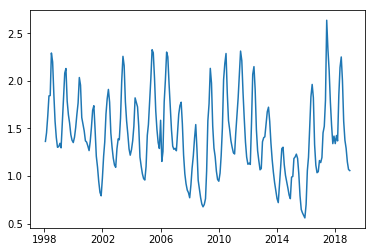

In [323]:
plt.plot(dt_idx,total_s*1.23348e-6)

In [324]:
# Calculate monthly means
means = pd.DataFrame.from_dict(rs_df).mean(axis = 0)
m = pd.DataFrame(means* 1.23348e-6, index = means.index)
m.columns = ["storage"] 

In [325]:
avg_stage = within_cv.merge(m, left_on = "ID", right_index = True)

In [326]:
# Extract some data for the plotting 
max_val = avg_stage['storage'].max()
med_val = avg_stage['storage'].median()
min_val = avg_stage['storage'].min()

f1 = avg_stage[avg_stage['storage'] == max_val]
f2 = avg_stage[avg_stage['storage'] == med_val]
f3 = avg_stage[avg_stage['storage'] == min_val]

p1, p2, p3, = np.percentile(avg_stage['storage'],33), np.percentile(avg_stage['storage'],50), np.percentile(avg_stage['storage'],90)

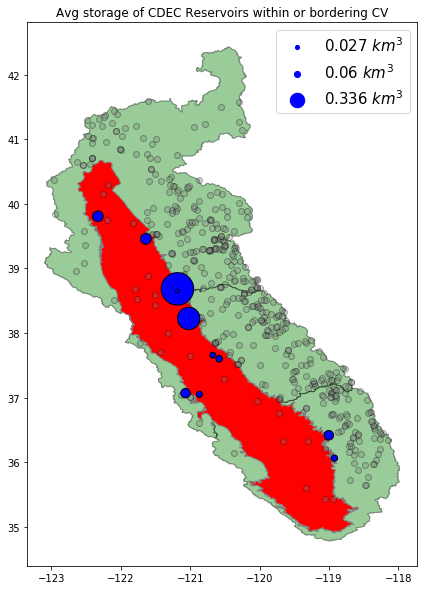

In [327]:
fig, ax = plt.subplots(figsize = (7, 10))

plt.title("Avg storage of CDEC Reservoirs within or bordering CV")
ssjt.plot(ax = ax, color = "green", alpha = 0.4, edgecolor = "black",label =  "SSJT HU4 watershed")
cv.plot(ax = ax, color = "red", edgecolor = "gray", label = "CV alluvial fill")
# gdf.plot(ax = ax, color = "blue", alpha = 0.1, edgecolor='black', label = "CDEC Reservoirs")
within_ssjt.plot(ax = ax, color = "gray", alpha = 0.3, edgecolor='black')
avg_stage.plot(ax = ax, markersize = avg_stage.storage*1500, color = "blue", alpha = 1, edgecolor='black')

avg_stage.plot(ax = ax, marker = ".", c = "blue", markersize = p1, label = "{} $km^3$".format(round(p1,3)))
avg_stage.plot(ax = ax, marker = ".", c = "blue", markersize = p2, label = "{} $km^3$".format(round(p2,3)))
avg_stage.plot(ax = ax, marker = ".", c = "blue", markersize = p3, label = "{} $km^3$".format(round(p3,3)))

plt.legend(markerscale = 50, prop={'size': 15})

plt.show()

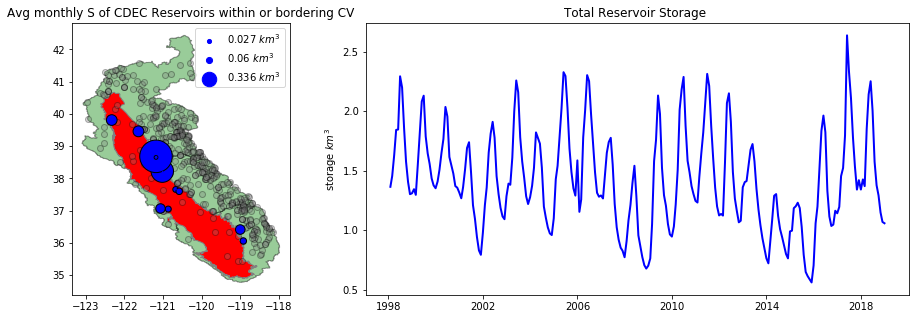

In [349]:
f, (ax, a0) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[2, 5]}, figsize=(15,5))

ax.set_title("Avg monthly S of CDEC Reservoirs within or bordering CV")
ssjt.plot(ax = ax, color = "green", alpha = 0.4, edgecolor = "black",label =  "SSJT HU4 watershed")
cv.plot(ax = ax, color = "red", edgecolor = "gray", label = "CV alluvial fill")
within_ssjt.plot(ax = ax, color = "gray", alpha = 0.3, edgecolor='black')
avg_stage.plot(ax = ax, markersize = avg_stage.storage*1500, color = "blue", alpha = 1, edgecolor='black')

avg_stage.plot(ax = ax, marker = ".", c = "blue", markersize = p1, label = "{} $km^3$".format(round(p1,3)))
avg_stage.plot(ax = ax, marker = ".", c = "blue", markersize = p2, label = "{} $km^3$".format(round(p2,3)))
avg_stage.plot(ax = ax, marker = ".", c = "blue", markersize = p3, label = "{} $km^3$".format(round(p3,3)))

ax.legend(markerscale = 50, prop={'size': 10}) # loc='upper center', bbox_to_anchor=(0.5, -0.07), fancybox=True, shadow=True,

a0.set_title("Total Reservoir Storage ")
a0.plot(dt_idx,total_s*1.23348e-6, label = "Total Reservoir Storage (USGS)", color = "blue", linewidth = 2.0)
a0.set_ylabel("storage $km^3$")

plt.savefig("../figs/monthly_res_storage_timeseries.png")

plt.show()

In [345]:
out = pd.DataFrame([total_s*1.23348e-6]).T
out.columns = ['storage_km3']
out.index = dt_idx
out.head()

,storage_km3
1998-01-31,1.363617
1998-02-28,1.454040
1998-03-31,1.631006
1998-04-30,1.841404
1998-05-31,1.844954


In [347]:
out.to_csv("../data/reservoir_storage.csv")